Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [47]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [48]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [49]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Instances generation

### Data

In [61]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

INIT_SOL_TH = 1

#### Generator function

In [51]:
def generate_data(universe_size, num_sets, density):
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    
    return SETS, COSTS

## Helper Functions

In [52]:
def valid(sets, solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(sets[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered

def coverage(sets, solution):
    """Returns the number of covered elements in the universe"""
    phenotype = np.logical_or.reduce(sets[solution])    # at least each element covered by a set
    return np.sum(phenotype)                            # number of covered elements    

def cost(costs, solution):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

def fitness(sets: np.ndarray, costs: np.ndarray, solution: np.ndarray):
    """Returns the fitness of the given solution"""
    return (coverage(sets, solution), -cost(costs, solution))

### RM hill climbing with single mutation

In [53]:
def single_mutation(solution: np.ndarray):
    pos = rng.integers(0, solution.shape[0])
    solution[pos] = not solution[pos]
    return solution

In [85]:
def solve_single_mutation_HC(sets, costs, num_sets, num_steps=10_000):
    
    history = []
    solution = rng.random(num_sets) < INIT_SOL_TH
    sol_fitness = fitness(sets, costs, solution)

    print(f"Initial fitness: {sol_fitness}")

    history.append(float(sol_fitness[1]))
    for _ in tqdm(range(num_steps)):
        current = single_mutation(solution.copy())
        curr_fitness = fitness(sets, costs, current)
        
        history.append(float(curr_fitness[1]))
        if curr_fitness > sol_fitness:
            solution = current
            sol_fitness = curr_fitness

    print(f"Final fitness: {sol_fitness}")
    print(f"Last update at iteration {history.index(float(sol_fitness[1]))}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")
    
    return sol_fitness

### RM hill climbing with multiple mutation

In [55]:
def multiple_mutation(solution: np.ndarray):
    mask = rng.random(solution.shape[0]) < 0.99
    new_solution = np.logical_xor(mask, solution)
    return new_solution

In [84]:
def solve_multiple_mutation_HC(sets, costs, num_sets, num_steps=10_000):
    history = []
    solution = rng.random(num_sets) < INIT_SOL_TH
    sol_fitness = fitness(sets, costs, solution)

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for _ in tqdm(range(num_steps)):
        current = single_mutation(solution.copy())
        curr_fitness = fitness(sets, costs, current)
        
        history.append(curr_fitness[1])
        if curr_fitness > sol_fitness:
            solution = current
            sol_fitness = curr_fitness

    print(f"Final fitness: {sol_fitness}")
    print(f"Last update at iteration {history.index(float(sol_fitness[1]))}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".")
    
    return sol_fitness

### Simulated annealing
It seems to perform worst than a RMHC: too much going around and not exploit neighboring solutions.

In [144]:
def solve_simulated_annealing_HC(sets, costs, num_sets, num_steps=10_000):
    
    def complete(covered):
        return covered == sets.shape[1]
    
    history = []
    solution = rng.random(num_sets) < INIT_SOL_TH
    sol_fitness = fitness(sets, costs, solution)
    final_sol_fitness = sol_fitness

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for i in tqdm(range(num_steps)):
        current = single_mutation(solution.copy())      # using single mutation to avoid too much exploration
        curr_fitness = fitness(sets, costs, current)
        
        # Exploring when high coverage, exploiting otherwise
        # Min temperature set to 1 to avoid numerical issues in scalar power
        temperature = max(1, 10 * (sol_fitness[0] / sets.shape[1]) + 0.01)
        
        history.append(sol_fitness[1])
        p = (np.e ** ((curr_fitness[1] - sol_fitness[1]) / temperature))
        #if curr_fitness[1] < sol_fitness[1]:
            #print(sol_fitness[0], curr_fitness[0], final_sol_fitness[0], temperature, p)
        if curr_fitness < sol_fitness and rng.random() < p or curr_fitness > sol_fitness:
            
            if curr_fitness > final_sol_fitness and complete(curr_fitness[0]):
                final_sol_fitness = curr_fitness
            
            sol_fitness = curr_fitness
            solution = current

    print(f"Final fitness: {final_sol_fitness}")
    print(f"Last update at iteration {history.index(final_sol_fitness[1])}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    return final_sol_fitness

### Tabu search
It uses a simulated annealing hill climber, but with discarding tweaked solution with a coverage under 80% on the universe. In this way, too much exploration in discouraged.

In [145]:
def solve_tabu_search_SAHC(sets, costs, num_sets, num_steps=10_000):
    
    def complete(covered):
        return covered == sets.shape[1]
    
    NUM_CANDIDATES = 10
    history = []
    solution = rng.random(num_sets) < INIT_SOL_TH
    sol_fitness = fitness(sets, costs, solution)
    final_sol_fitness = sol_fitness

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for i in tqdm(range(num_steps)):
        tmp = [single_mutation(solution.copy()) for _ in range(NUM_CANDIDATES)]
        candidates = [sol for sol in tmp if coverage(sets, sol) / sets.shape[1] > 0.8]
        
        for current in candidates:
            curr_fitness = fitness(sets, costs, current)
            
            # Exploring when high coverage, exploiting otherwise
            # Min temperature set to 10 to avoid numerical issues in scalar power
            temperature = max(1, 10 * (sol_fitness[0] / sets.shape[1]) + 0.01)
            
            history.append(sol_fitness[1])
            p = (np.e ** ((curr_fitness[1] - sol_fitness[1]) / temperature))
            if curr_fitness < sol_fitness and rng.random() < p or curr_fitness > sol_fitness:
                
                if curr_fitness > final_sol_fitness and complete(curr_fitness[0]):
                    final_sol_fitness = curr_fitness
                
                sol_fitness = curr_fitness
                solution = current

    print(f"Final fitness: {final_sol_fitness}")
    print(f"Last update at iteration {history.index(final_sol_fitness[1])}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    return final_sol_fitness

### Approccio greedy
Ad ogni iterazione, si prende l'insieme che copre il maggior numero di elementi non ancora coperti.
Si itera fino a coprire tutti gli elementi nell'universo

In [58]:
def solve_greedy(sets: np.ndarray, costs: np.ndarray, num_sets) -> np.ndarray:
    
    solution = np.full(num_sets, False)
    set_matrix = sets.copy()
    covered = 0

    while covered < set_matrix.shape[1]:
        
        progress = 100 * covered / set_matrix.shape[1]
        print(float(progress), end=" ")
        
        largest_index = np.argmax(set_matrix.sum(axis=1))
        largest = set_matrix[largest_index, :]
        solution[largest_index] = True
        covered += largest.sum()
        
        for j in range(largest.shape[0]):
            if largest[j]:
                set_matrix[:, j] = False
                
    print()
    
    return fitness(sets, costs, solution)

## Greedy solver
It has memory issues for instance 4

In [ ]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

for (i, (UNIVERSE_SIZE, NUM_SETS, DENSITY)) in enumerate(zip(universe_sizes, num_sets_sizes, densities)):

    print(f"Generating instance {i+1}")

    SETS, COSTS = generate_data(UNIVERSE_SIZE, NUM_SETS, DENSITY)

    print(f"Solving instance {i+1}")
    
    solution = solve_greedy(SETS.copy())

    fitness_sol = fitness(solution)
    print()
    print(fitness_sol)

## General solver
Script to solve task with multiple strategies and perform comparisons

In [139]:
class Strategies:
    SINGLE_MUTATION_HC = "Single mutation hill climber"
    MULTIPLE_MUTATION_HC = "Multiple mutation hill climber"
    SIMULATED_ANNEALING = "Simulated annealing hill climber"
    TABU_SEARCH = "Tabu search hill climber"
    GREEDY = "Greedy"
    
    def to_list():
        return [
            Strategies.SINGLE_MUTATION_HC,
            Strategies.MULTIPLE_MUTATION_HC,
            Strategies.SIMULATED_ANNEALING,
            Strategies.TABU_SEARCH,
            Strategies.GREEDY
        ]

def solve(sets: np.ndarray, costs: np.ndarray, strategy: str):
    n = sets.shape[0]
    u = sets.shape[1]
    steps = int(min(n*u // 50, 10_000))
    match strategy:
        case Strategies.SINGLE_MUTATION_HC:
            return solve_single_mutation_HC(sets, costs, n, num_steps=steps)
        case Strategies.MULTIPLE_MUTATION_HC:
            return solve_multiple_mutation_HC(sets, costs, n, num_steps=steps)
        case Strategies.SIMULATED_ANNEALING:
            return solve_simulated_annealing_HC(sets, costs, n, num_steps=10_000)
        case Strategies.TABU_SEARCH:
            return solve_tabu_search_SAHC(sets, costs, n, num_steps=2000)
        case Strategies.GREEDY:
            return solve_greedy(sets, costs, n)

Generating instance 1
Solving instance 1
Initial fitness: (np.int64(100), np.float64(-276.5882163803949))


  0%|          | 0/20 [00:00<?, ?it/s]

Final fitness: (np.int64(100), np.float64(-276.5882163803949))
Last update at iteration 0


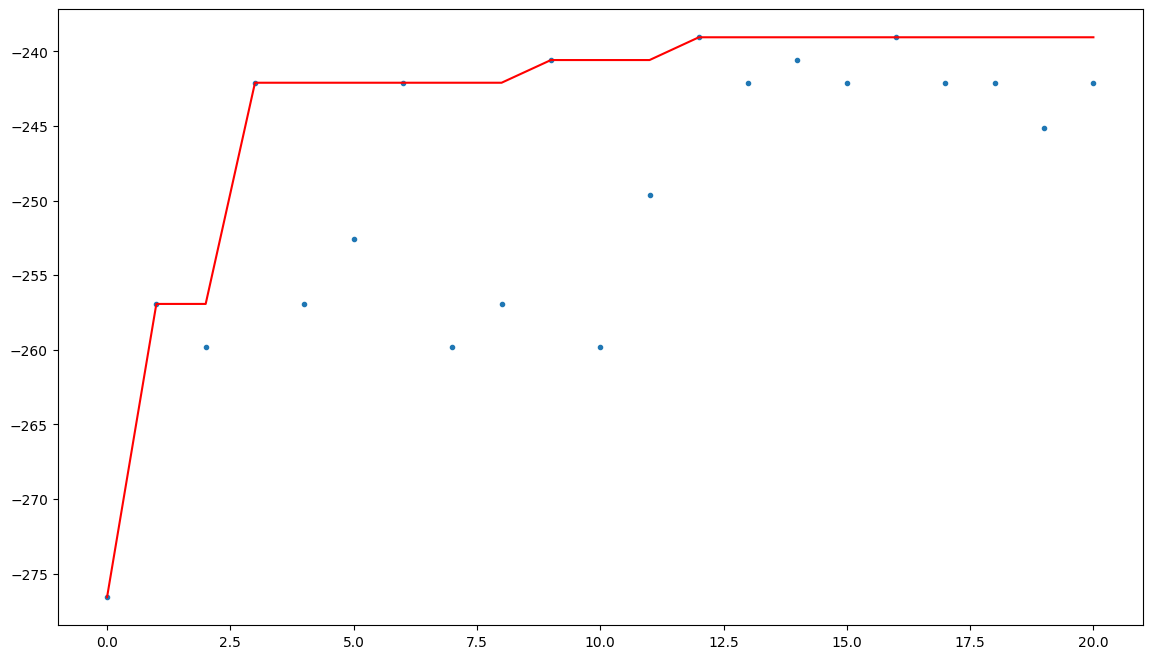

Initial fitness: (np.int64(100), np.float64(-276.5882163803949))


  0%|          | 0/20 [00:00<?, ?it/s]

Final fitness: (np.int64(100), np.float64(-276.5882163803949))
Last update at iteration 0


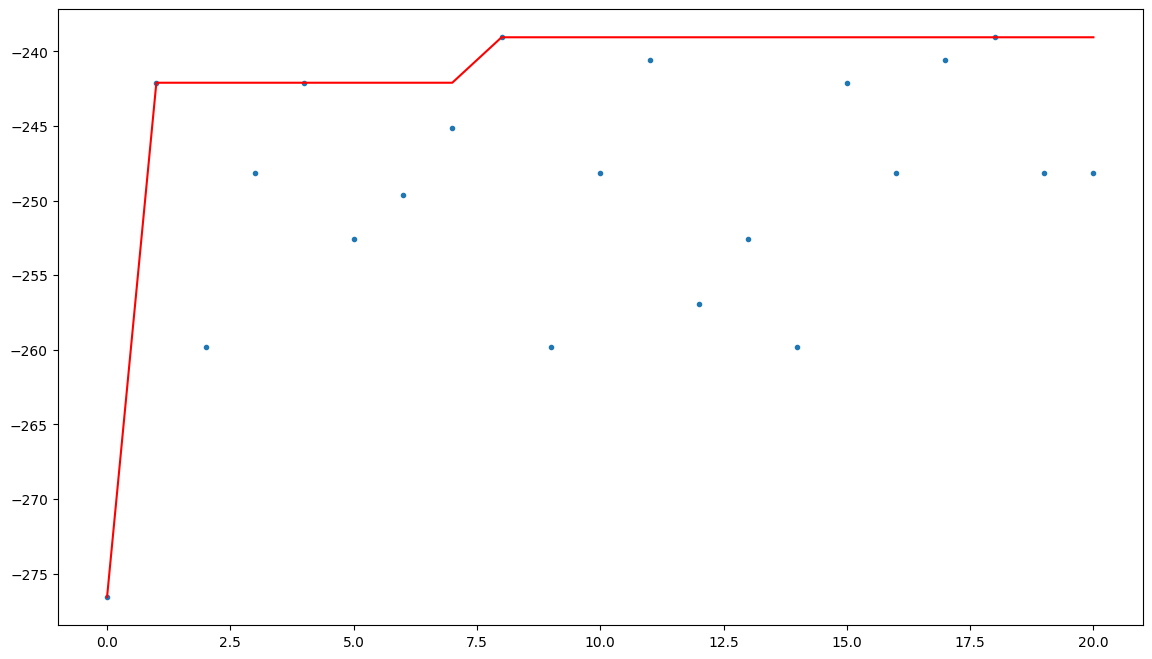

Initial fitness: (np.int64(100), np.float64(-276.5882163803949))


  0%|          | 0/10000 [00:00<?, ?it/s]

Final fitness: (np.int64(100), np.float64(-276.5882163803949))
Last update at iteration 0


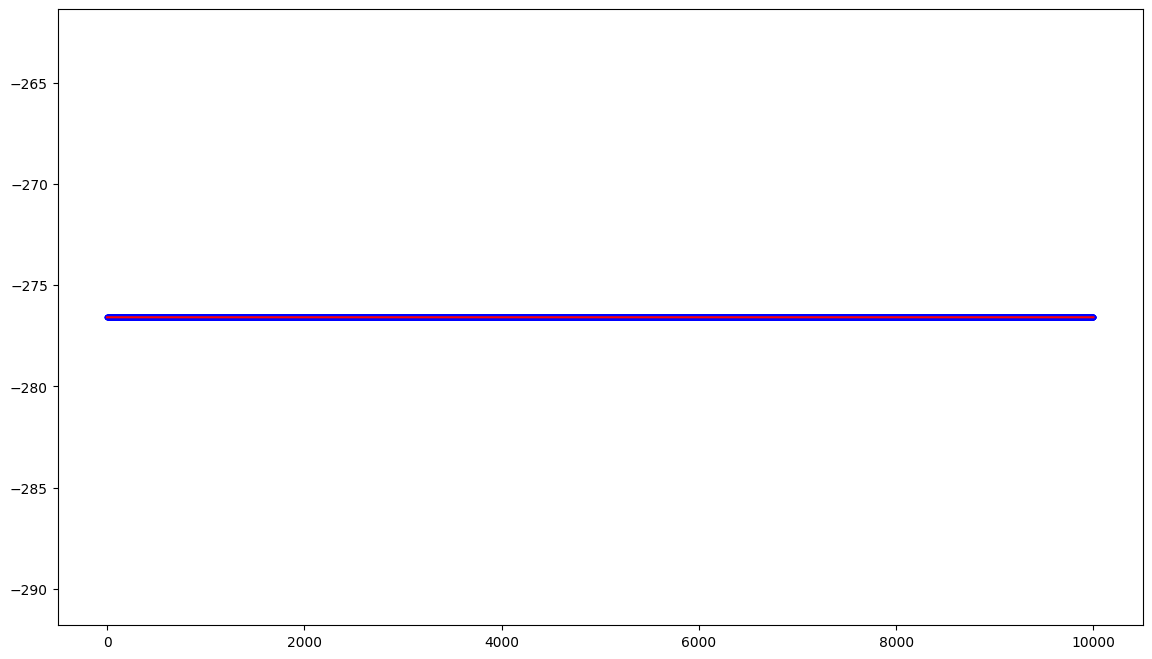

Initial fitness: (np.int64(100), np.float64(-276.5882163803949))


  0%|          | 0/2000 [00:00<?, ?it/s]

Final fitness: (np.int64(100), np.float64(-276.5882163803949))
Last update at iteration 0


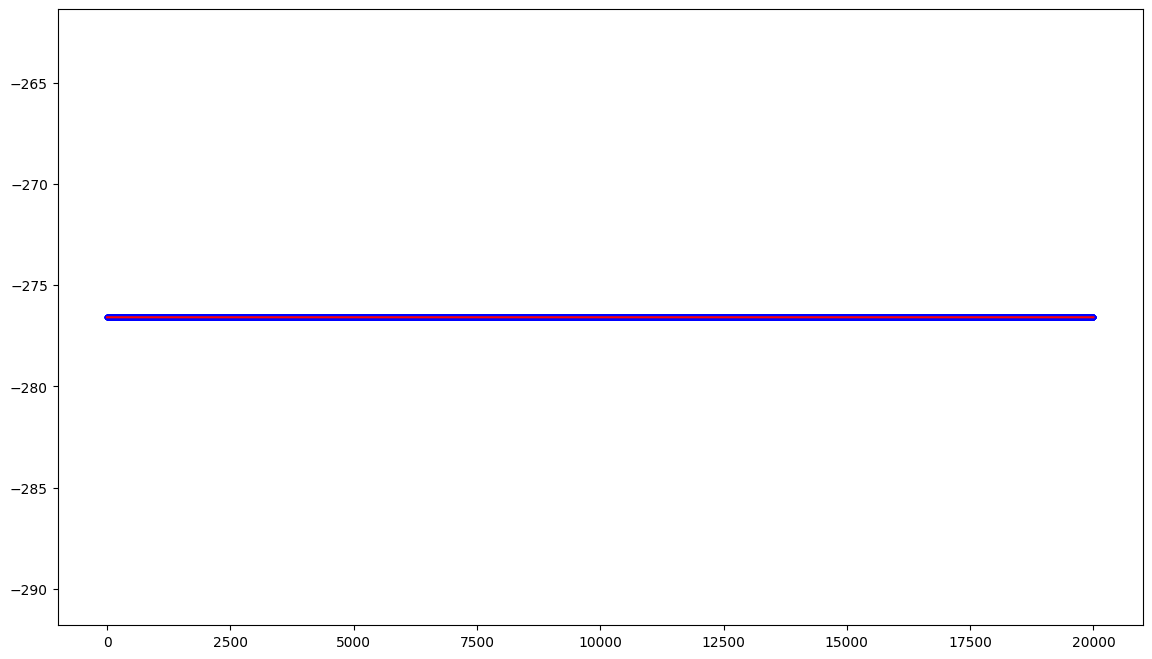

0.0 27.0 49.0 64.0 76.0 84.0 90.0 94.0 97.0 99.0 
Single mutation hill climber: (np.int64(100), np.float64(-276.5882163803949))
Multiple mutation hill climber: (np.int64(100), np.float64(-276.5882163803949))
Simulated annealing hill climber: (np.int64(100), np.float64(-276.5882163803949))
Tabu search hill climber: (np.int64(100), np.float64(-276.5882163803949))
Greedy: (np.int64(100), np.float64(-276.5882163803949))
Generating instance 2
Solving instance 2
Initial fitness: (np.int64(1000), np.float64(-33696.531478137105))


  0%|          | 0/2000 [00:00<?, ?it/s]

Final fitness: (np.int64(1000), np.float64(-6861.611757072365))
Last update at iteration 303


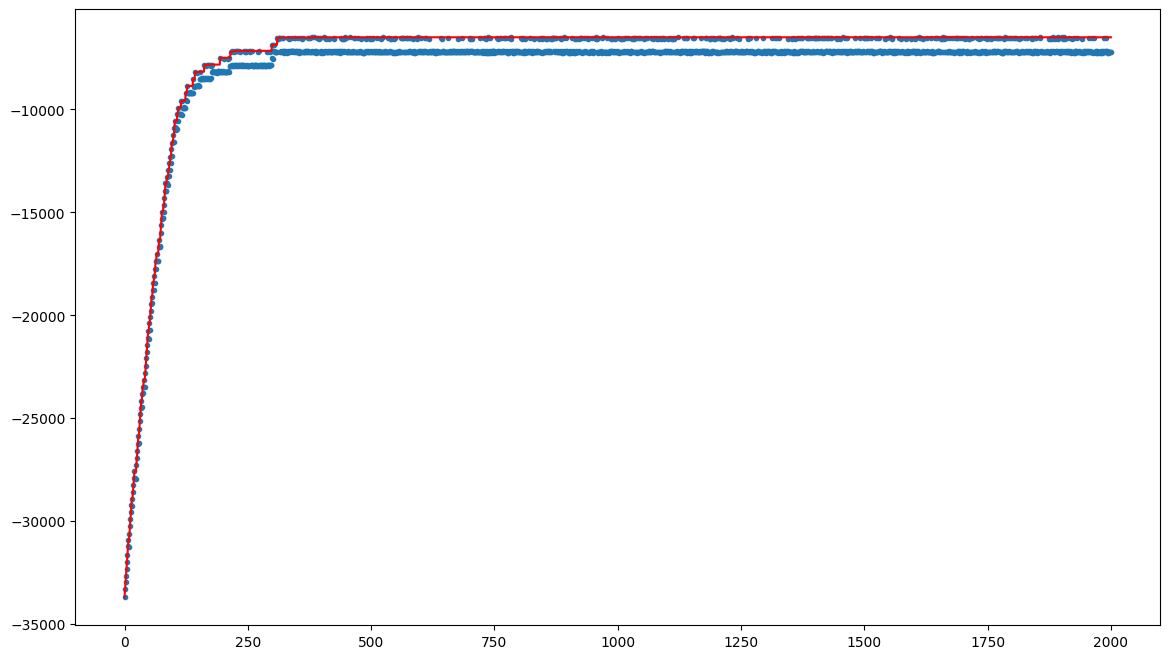

Initial fitness: (np.int64(1000), np.float64(-33696.531478137105))


  0%|          | 0/2000 [00:00<?, ?it/s]

Final fitness: (np.int64(1000), np.float64(-6839.166823408577))
Last update at iteration 235


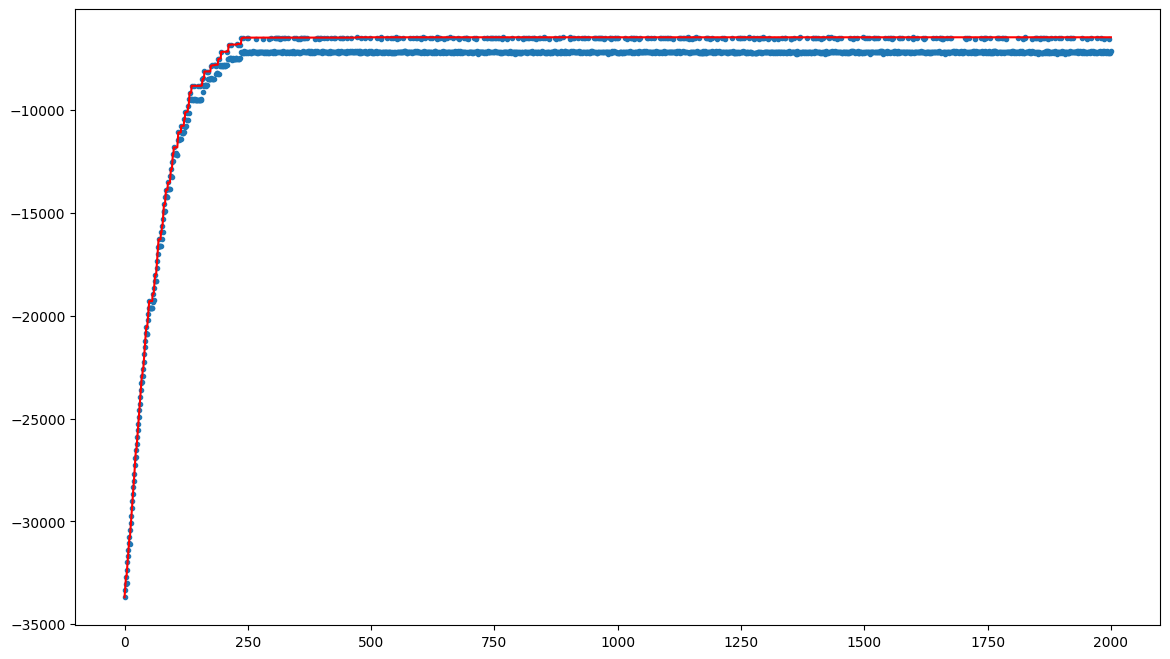

Initial fitness: (np.int64(1000), np.float64(-33696.531478137105))


  0%|          | 0/10000 [00:00<?, ?it/s]

Final fitness: (np.int64(1000), np.float64(-6851.826617278333))
Last update at iteration 419


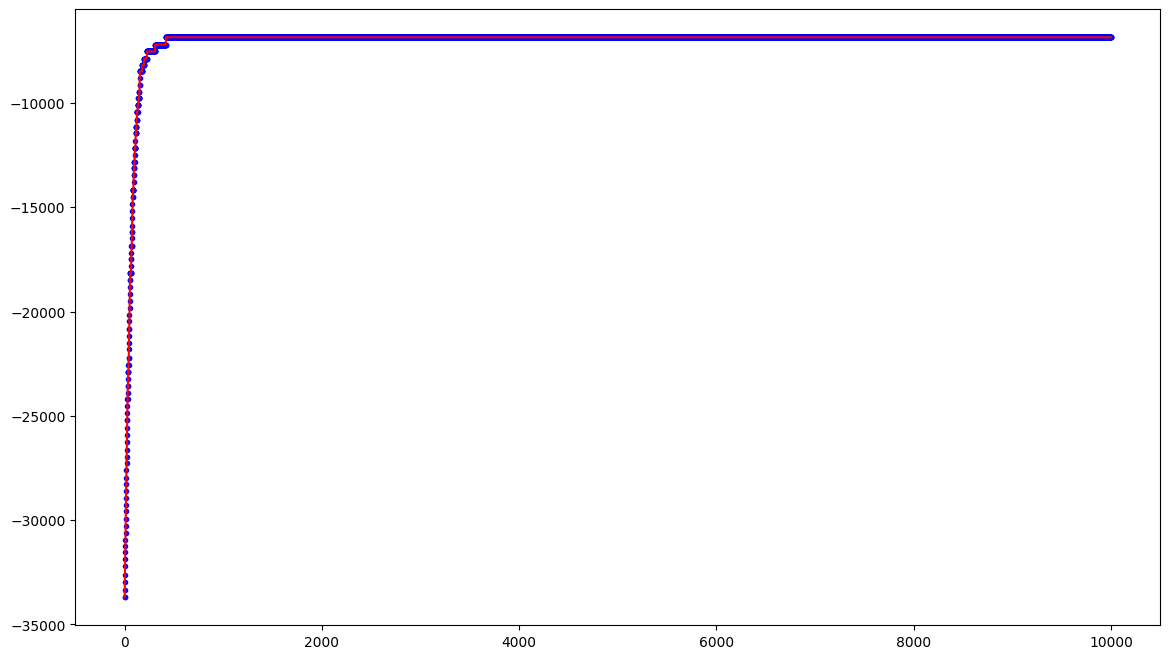

Initial fitness: (np.int64(1000), np.float64(-33696.531478137105))


  0%|          | 0/2000 [00:00<?, ?it/s]

Final fitness: (np.int64(1000), np.float64(-6942.291730790881))
Last update at iteration 1042


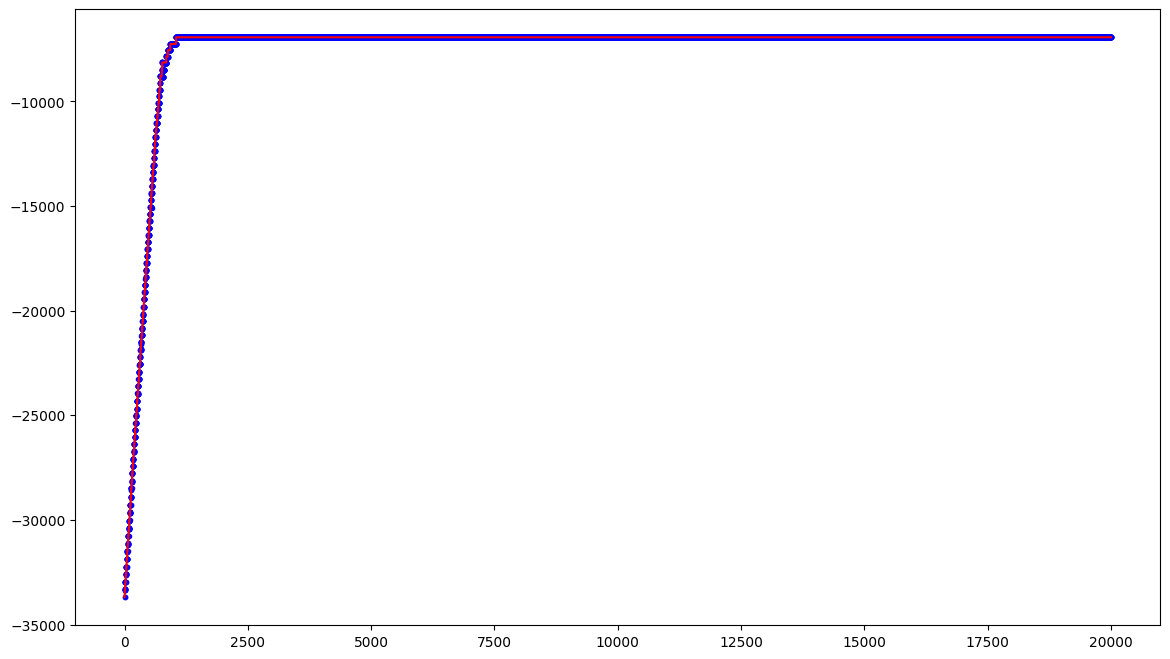

0.0 24.0 42.2 56.2 66.9 75.0 81.3 86.2 89.9 92.7 94.8 96.5 97.8 98.6 99.3 99.8 
Single mutation hill climber: (np.int64(1000), np.float64(-6861.611757072365))
Multiple mutation hill climber: (np.int64(1000), np.float64(-6839.166823408577))
Simulated annealing hill climber: (np.int64(1000), np.float64(-6851.826617278333))
Tabu search hill climber: (np.int64(1000), np.float64(-6942.291730790881))
Greedy: (np.int64(1000), np.float64(-5719.669283394705))
Generating instance 3
Solving instance 3
Initial fitness: (np.int64(10000), np.float64(-4277408.733782325))


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [146]:
for (i, (universe_size, num_sets, density)) in list(enumerate(zip(universe_sizes, num_sets_sizes, densities)))[:3]:

    print(f"Generating instance {i+1}")

    SETS, COSTS = generate_data(universe_size, num_sets, density)

    print(f"Solving instance {i+1}")
    
    fitnesses = {}
    for strategy_name in Strategies.to_list():
        fitnesses[strategy_name] = solve(SETS, COSTS, strategy_name)
        plt.show()

    for (strategy, fitness_val) in fitnesses.items():
        print(f"{strategy}: {fitness_val}")